In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("drawndata1.csv")

In [6]:
df.head(3)

,x,y,z
0,58.080365,225.699042,a
1,238.867357,247.456645,a
2,156.218212,286.588782,a


In [8]:
X = df[["x", "y"]].values
y = df["z"] == "a"

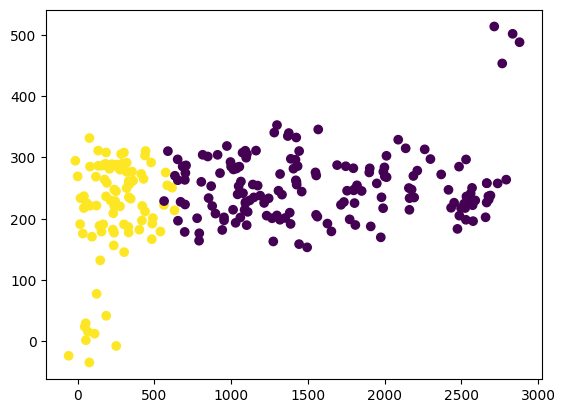

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=y)

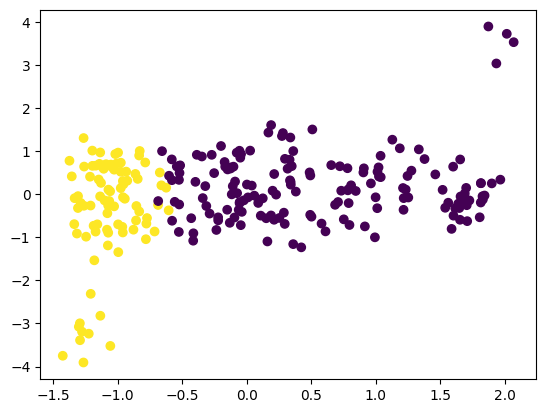

In [24]:
# We want to rescale the data so that we will be numerically more stable
# We can use StandardScaler() ==> It will do the following for each column in the dataset (X-mean(X))/(std)  ==> This will give us data that revolves around 0.
from sklearn.preprocessing import StandardScaler
X_new = StandardScaler().fit_transform(X)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y)
# We will notice that the axes are now numerically much more similar. But, it is still not perfect. The y-axis represents around 8 units while the x-axis represents around 3.5 units. And, we can see that nothing happened to the outliers.


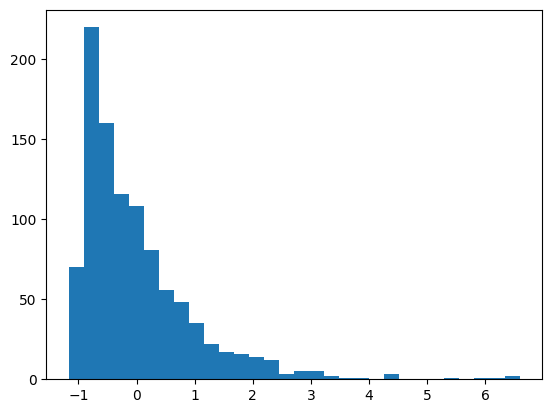

In [50]:
# Showing the weakness of the standard scaller -- We can see that after scaling the data, we still have outliers 
seed_val = 20
np.random.seed(seed_val)
x = np.random.exponential(10, (1000)) + np.random.normal(0,1, (1000))
x_new = (x - np.mean(x))/np.std(x)
plt.hist(x_new, 30);

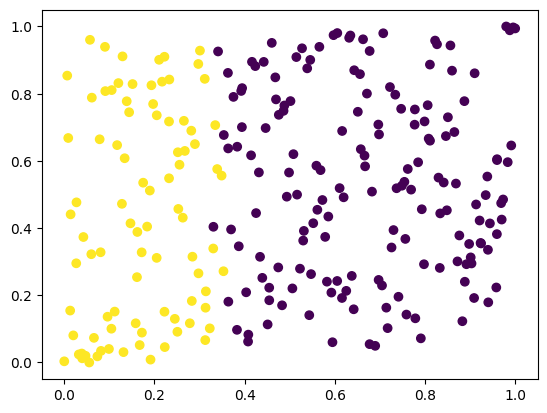

In [52]:
# However, by using quantiles instead of standard deviations for scalling, we may be able to have a more robust pre-processing step if there are outliers
from sklearn.preprocessing import QuantileTransformer
X_new = QuantileTransformer(n_quantiles=100).fit_transform(X)  # we reduced the number of quantiles to 100 because by default, scikit-learn calculates 1000 quantiles. But, our dataset doesn't have enough data for this.
plt.scatter(X_new[:, 0], X_new[:, 1], c=y)

# We can notice the minimum and maximum on both axes are both = 0 and = 1. And, we notice that the previous outliers now have less of an effect on the data.

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
# Function that allowws us to pass through a transformer, then it will train a K Nearest Neighbor model and then produce predictions. This will allows us to see the difference that a transformer can make to a model.
def plot_output(scaler):
    pipe = Pipeline([
        ("scale", scaler),
        ("model", KNeighborsClassifier(n_neighbors=20, weights='distance'))
    ])

    pred = pipe.fit(X, y).predict(X)

    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Original Data")
    plt.subplot(132)
    X_tfm = scaler.transform(X)
    plt.scatter(X_tfm[:, 0], X_tfm[:, 1], c=y)
    plt.title("Transformed Data")
    plt.subplot(133)
    X_new = np.concatenate([
        np.random.uniform(0, X[:, 0].max(), (5000, 1)), 
        np.random.uniform(0, X[:, 1].max(), (5000, 1))
    ], axis=1)
    y_proba = pipe.predict_proba(X_new)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=y_proba[:, 1], alpha=0.7)
    plt.title("Predicted Data")

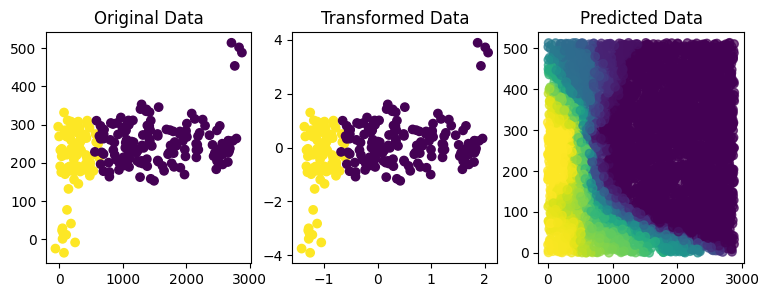

In [68]:
# Results using a StandardScaller
plot_output(scaler=StandardScaler())
# We can see that the model is predicting the yellow class for data going beyond x=1000 and below y=100

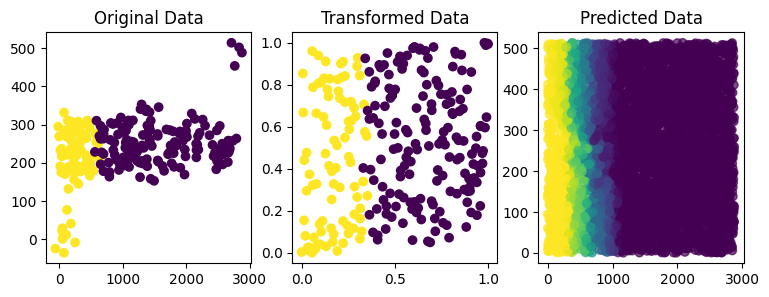

In [72]:
# Results using a QuantileTransfoermer
plot_output(scaler=QuantileTransformer())
# Since the transformed data is much less influenced by the outliers, we will notice that the model able to think that there is a dividing line between the classes (at around x=0.4 in the transformed data). 
# And, we can see a big difference between the predictions of the model scaled with the QuantileTransformer when compared to the model scaled with the StandardScaler.
# In this case, the QuantileTransformer does has benefits. But it would still be a good idea to verify this with a GridSearch. And, with GridSearch, the model will be more stable in the long run because the outliers will not have much of an effect anymore.

In [ ]:
# ------------------------------------------------------------ Dataset 2 ------------------------------------------------------------

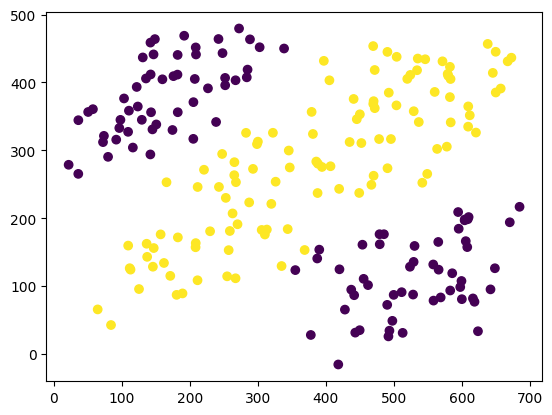

In [77]:
# This dataset represents a classification task that is not linearly separable (we cannot divide the data by a single line -- So a logistic regression may not be the right algorithm for this task)
df = pd.read_csv("drawndata2.csv")
X = df[["x", "y"]].values
y = df["z"] == "a"
plt.scatter(X[:,0], X[:,1], c=y)

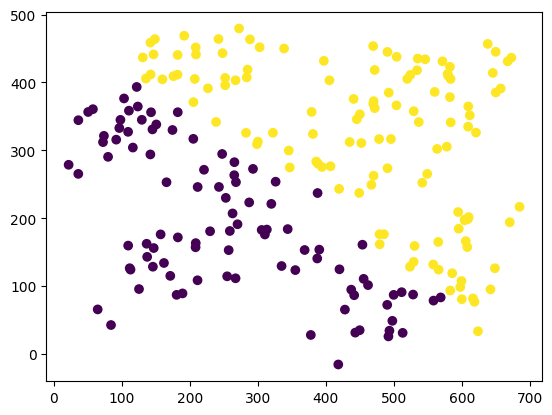

In [78]:
# Let's verify this
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scale", QuantileTransformer(n_quantiles=100)),
    ("model", LogisticRegression())
])

pred = pipe.fit(X, y).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred);
# We can see that the logistic regression is only separating the data by a single diagonal line. So, it is not the right algorithm to use in this case. But, we can fix this with preprocessing.

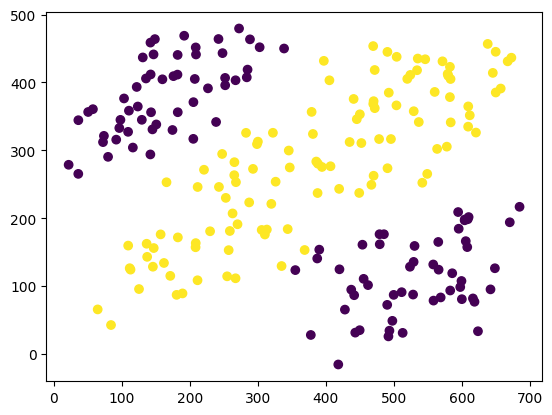

In [80]:
# We curently have a feature (column of data) representing the data on the x-axis (let's call this feature X1) and another feature representing the data on the y-axis (let's call this feature X2). 
# However, we can create new features that our model can then use, such as : X1*X2, X1^2, X2^2 ==> These will be non-linear features, as opposed to X1 and X2 which are linear features.
# Let's try to add these features to our pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scale", PolynomialFeatures()),
    ("model", LogisticRegression())
])

pred = pipe.fit(X, y).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred);
# We can see now that we have a clear perfect classification of the data using the model (but we are still using the training set to predict the output -- which we should not be doing). 
# But, the idea was to see how much a pre-processing step has an effect on the pipeline.

In [82]:
# ------------------------------------------------------------ Dataset 3 ------------------------------------------------------------
# We can have non-numerical data, and then perform pre-processing to convert it to numeric data.
arr = np.array(["low", "low", "high", "medium"]).reshape(-1, 1)
arr

array([['low'],
       ['low'],
       ['high'],
       ['medium']], dtype='<U6')

In [86]:
# To do this we can use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)  # We set sparce=False to see the values of the resulting matrix
enc.fit_transform(arr)
# We can see the first 2 rows reprent the "low" value since they are on the same column, and the "high" and "medium" values are on separate column in the matrix.
# This matrix can the be used as our predictions (y) in case `arr` is the dataset that we want to predict.

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [88]:
# Howevedr, we should be cautions when using OneHotEncoder in case we give it data that it did not see before
enc.transform([["zero"]])  # we are asking the encoder to give us a label for `zero`. But `zero` was not in the dataset that was used to fit the transformer

ValueError: Found unknown categories ['zero'] in column 0 during transform

In [90]:
# To fix this issue, we can change the settings of the encoder 
enc = OneHotEncoder(sparse=False, handle_unknown="ignore")  # handle_unknown="ignore" is very useful when we are generating our `X` matrix. But, it should never be used when generating our labels `y`. Because, we want to have very strict control over our labels.
enc.fit_transform(arr)

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [92]:
# Now, if we ask the encoder to provide us with a label for `zero`
enc.transform([["zero"]])  # We did not get an error. And, it is telling us that `zero` is neither `low`, `medium` or `high` since the result is np.array([0, 0, 0])

array([[0., 0., 0.]])